#Data Story Project "London Underground data"

***

##Description and data sources

The current project aims to provide useful insights on usage of London tube and help Londoners to plan their journeys.
The project uses two data sets:

   ** 1. Oyster card data**
   
    This dataset provides a 5% sample of all Oyster card journeys performed in a week during November 2009 on bus, Tube, DLR and London Overground.
    
   ** 2. London Underground passenger counts data**
    
    Passenger counts collects information about passenger numbers entering and exiting London Underground stations, largely based on the Underground ticketing system gate data.
    
**Data source: "Transport for London" (https://api-portal.tfl.gov.uk/)**

***

##Loading modules

In [283]:
import pandas as pd
import numpy as np
import os
import folium

%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14, 'font.family': 'serif'})

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

import itertools

In [284]:
import random

COLORS = [(139, 0, 0), 
          (0, 100, 0),
          (0, 0, 139)]

def random_color():
    return random.choice(COLORS)

***

##Loading data

In [285]:
data_folder = 'C:\\data_science_intensive\\Data_story_project\\London Underground data'
os.chdir(data_folder)

***

### Importing Oyster card data

In [286]:
file_oyster = 'Nov09JnyExport.csv'
data_oyster = pd.read_csv(file_oyster)
len(data_oyster) #the data set contains 2623487 data entries

2623487

**Column descriptions**

- downo - a number between 1 and 7, 1 being Sunday, 2 being Monday etc
- daytype - Sun to Sat
- SubSystem - the mode(s) of the journey. LUL - London Underground, NR - National Rail, LTB - London Buses, DLR- Docklands Light - Railway, LRC - London Overground, TRAM - Croydon Tram
- StartStn - Station the journey started at
- EndStation - Station the journey ended at
- EntTime - Entry time of the journey in minutes after midnight
- EntTimeHHMM - Entry time in HH:MM text format
- ExTime - Exit time of the journey in minutes after midnight
- EXTimeHHMM - Exit time in HH:MM text format
- ZVPPT - zones of Oyster Season ticket, if used
- JNYTYP - Product types involved in the journey. PPY - Pure PAYG, TKT - Pure Oyster Season, MIXED - Combined PAYG and Oyster  Season
- DailyCapping - it shows as Y when PAYG journey was capped
- FFare - Full PAYG Fare before any discounts
- Dfare - PAYG Fare after usage based discounts
- RouteID - The Route Number of the Bus, if a Bus has been boarded
- FinalProduct - Combined Product Description used for journey

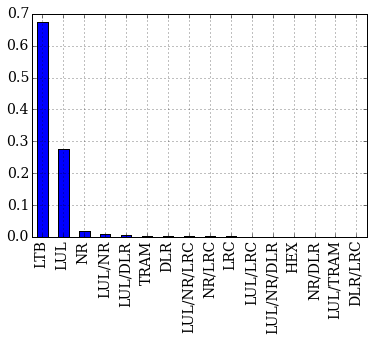

In [287]:
df_subsystems = (data_oyster.SubSystem).value_counts()/len(data_oyster)
plt.figure()
ax = df_subsystems.plot(kind = 'bar');
#ax.set_xlabel("Transport Systems", fontweight = 'bold')
#ax.set_ylabel("Percentage", fontweight = 'bold')
#plt.tight_layout()

The majority of data entries are related to trips by London Buses (67%) and London Tube (28%)

In [288]:
#Bus
data_oyster_bus = data_oyster[data_oyster.SubSystem == 'LTB']
# Removing irrelevant columns (for example, there is no information on exit time of the journey if a Bus was used)
data_oyster_bus.drop(['StartStn','EndStation', 'ExTime', 'EXTimeHHMM', 'FFare', 'DFare'], axis=1, inplace=True)

In [289]:
#Tube
data_oyster_tube = data_oyster[data_oyster.SubSystem == 'LUL']

In [290]:
data_oyster_tube.StartStn.unique() #StartStn column contains 'Unstarted' values (20283 rows in total)
len(data_oyster_tube[data_oyster_tube.StartStn == 'Unstarted'])
data_oyster_tube = data_oyster_tube[data_oyster_tube.StartStn != 'Unstarted'] #removing rows that have no information of start stations

In [291]:
data_oyster_tube.EndStation.unique()
len(data_oyster_tube[data_oyster_tube.EndStation == 'Not Applicable']) #EndStation column contains 'Not Applicable' values (1 row)
data_oyster_tube = data_oyster_tube[(data_oyster_tube.EndStation != 'Not Applicable') & (data_oyster_tube.EndStation !='Unfinished')] #removing rows that have no information of end stations

***

### Importing London Underground passenger counts data

In [292]:
file_count_weekday = 'En 12Week.xls'
file_count_sat = 'En12sat.xls'
file_count_sun = 'En12sun.xls'

In [293]:
def read_xls_count_data(filename, Sheetname, ncolsskip):
    df = pd.read_excel(filename, Sheetname, skiprows = 6,skip_footer =2)
    df.drop(df.columns[-ncolsskip:], axis=1, inplace=True)
    df.drop(['nlc', 'Date', 'Note'], axis=1, inplace=True)
    df = df.set_index('Station')
    del df.index.name
    df['Total'] = df.sum(axis =1)
    return df

In [294]:
data_counts_week = read_xls_count_data(file_count_weekday, 'En Wk 12',7)
data_counts_sat = read_xls_count_data(file_count_sat, 'En SAT 2012',2)
data_counts_sun = read_xls_count_data(file_count_sun, 'En SUN 2012',2)

***

##London Underground passenger counts data analysis

###Busiest stations 

What are the busiest stations? (Bar plots; weekdays, Saturdays and Sundays separetly)

In [295]:
def plottopN(dfs, N, title, width = 0.25,color = 'black'):
    
    
    df = pd.DataFrame(dfs.order(ascending = False).head(N)) # selecting top N from the data Frame
    
    ind = np.arange(N)  # the x locations for the groups
    
    rects1 = plt.barh(ind, df['Total']/1000, width, alpha = 0.5, color=color)

    plt.yticks(ind+0.5*width)
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.title(title, fontweight = 'bold', fontsize = 20)
    plt.grid()
    plt.xlim([0,140])
    ytickNames = plt.gca().set_yticklabels(df['Total'].index)
    plt.setp(ytickNames, rotation=0, fontsize=14, fontweight = 'bold')
    

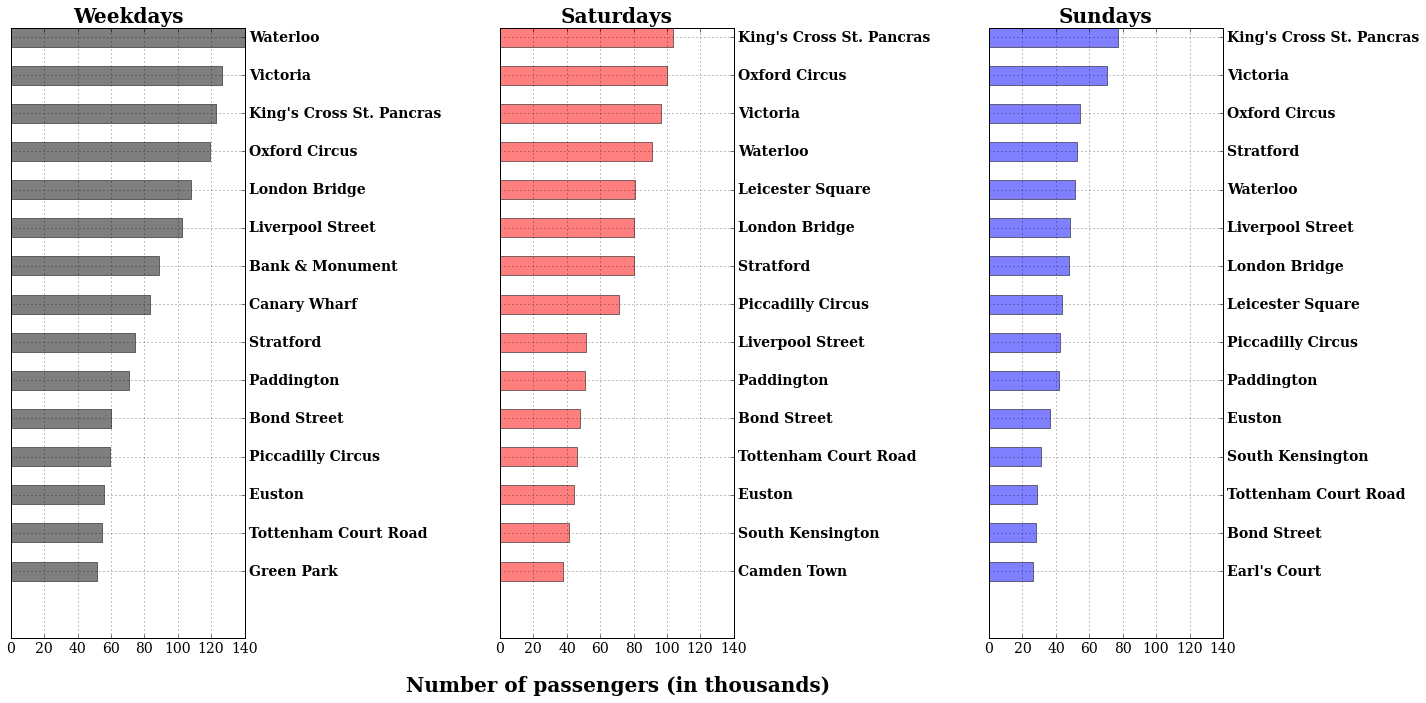

In [296]:
fig = plt.figure(figsize = (20,10))


N = 15 ## How many most busi
                
#plt.suptitle('London Underground passenger counts data', fontweight = 'bold', fontsize = 20) OVERLAPS!!
plt.subplot(131)
plottopN(data_counts_week['Total'], N, 'Weekdays', width = 0.5,color = 'black')

plt.subplot(132)
plottopN(data_counts_sat['Total'], N, 'Saturdays', width = 0.5,color = 'red')
plt.xlabel('Number of passengers (in thousands)', fontweight = 'bold', fontsize = 20, labelpad=20)

plt.subplot(133)
plottopN(data_counts_sun['Total'], N, 'Sundays', width = 0.5,color = 'blue')

plt.tight_layout()


What are the busiest stations? (Bar plots; weekdays, Saturdays and Sundays stucked)

In [297]:
N = 20 #How many stations I want to consider?

In [298]:
data_counts = pd.concat([data_counts_week['Total'], data_counts_sat['Total'], data_counts_sun['Total']], axis = 1)
data_counts.columns = ['Week', 'Saturday','Sunday']
data_counts['All_together'] = data_counts.sum(axis = 1)
data_counts_top10 = data_counts.sort(['All_together'], ascending=0).head(N)

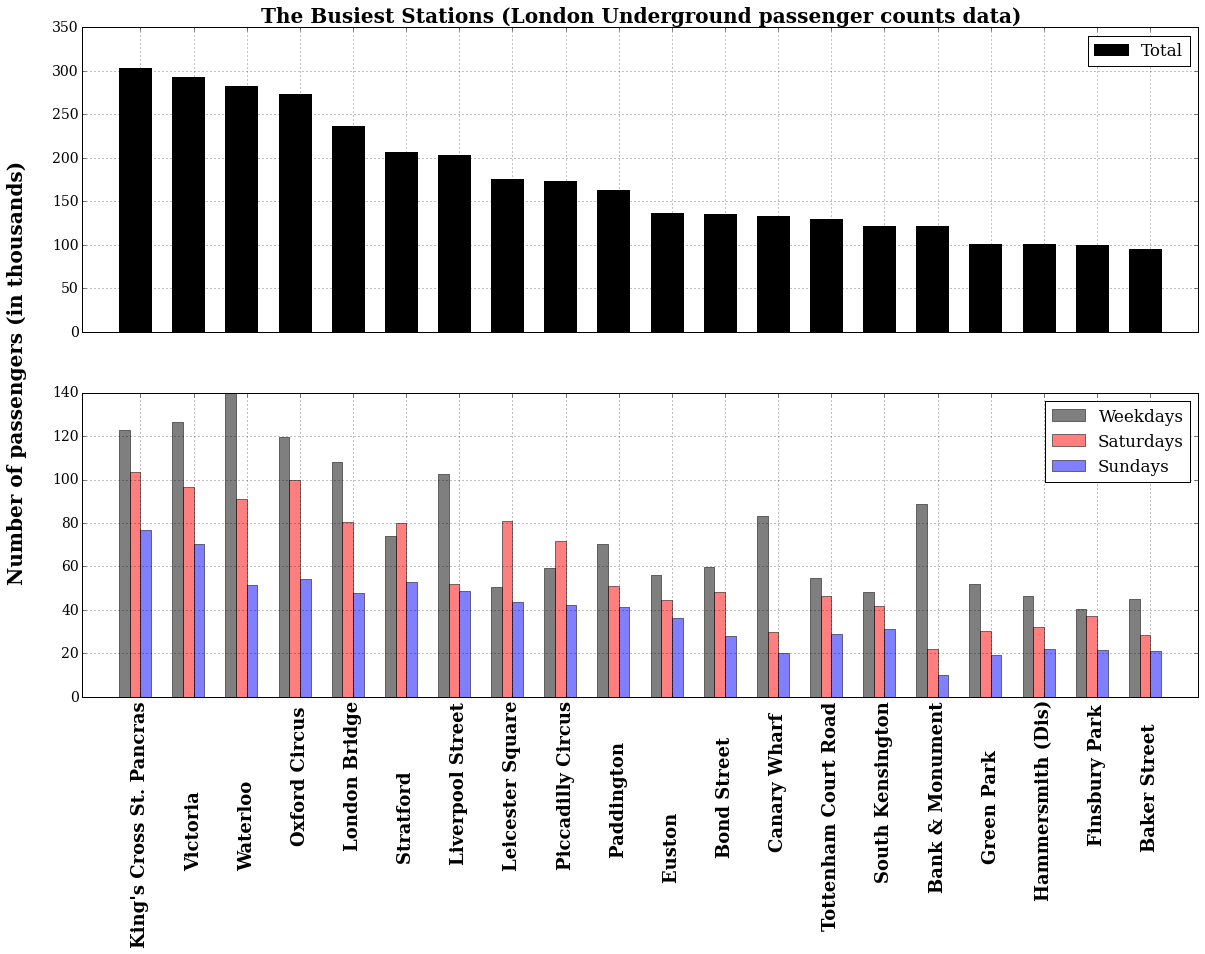

In [299]:
ind = np.arange(N)
width = 0.2

fig = plt.figure(figsize = (20,12))
ax0 = plt.subplot(211)
ax0.bar(ind, data_counts_top10['All_together']/1000,width*3,color='k',align='center', label = 'Total')
ax0.set_xlim([-1,N])
ax0.xaxis.set_major_formatter(plt.NullFormatter())
plt.grid()
plt.xticks(ind+0.5*width)
plt.legend(loc = 'best')
plt.title('The Busiest Stations (London Underground passenger counts data)', fontweight = 'bold', fontsize = 20)

ax = plt.subplot(212)
ax.bar(ind-width, data_counts_top10['Week']/1000,width, alpha = 0.5, color='k',align='center', label = 'Weekdays')
ax.bar(ind, data_counts_top10['Saturday']/1000,width,alpha = 0.5,color='r',align='center', label = 'Saturdays')
ax.bar(ind+width, data_counts_top10['Sunday']/1000,width, alpha = 0.5,color='b',align='center',label = 'Sundays')
plt.legend(loc = 'best')
plt.grid()
plt.xticks(ind+0.5*width)
plt.xlim([-1,N])
xtickNames = plt.gca().set_xticklabels(data_counts_top10.index, fontweight = 'bold', fontsize = 18, rotation = 90)

fig.text(0.08, 0.5, 'Number of passengers (in thousands)', fontweight = 'bold', fontsize = 20, ha='center', va='center', rotation='vertical')

###When are the busiest stations so busy? (Time series plot)

In [300]:
#Subsetting the data frames (only leave the busiest stations)
n_bs = 10 # Consider only top 10 for time series plot
busy_stations = data_counts_top10.head(n_bs).index
global busy_stations
mask = []
for a in data_counts_week.index:
    if a in busy_stations:
        mask.append(True)
    else:
        mask.append(False)
               

In [301]:
def modify_df_for_TS_plot(DF, mask):
    DF = DF.drop('Total', 1)
    DF = DF[mask].reindex(busy_stations)
    return DF.transpose()

In [302]:
c=np.random.rand(3,n_bs) #random colors for plotting

In [303]:
def timeseries_plot(df, c, n_bs):
    ind = np.arange(len(df.index))
    df.index = [datetime.strptime(t[0:4], '%H%M') for t in df.index]
    df = df.sort_index()
    for i in np.arange(n_bs):
        if i <4:
            line = 4
        else:
            line = 2
        plt.plot(df.index, df[df.columns[i]], color = c[:,i], linewidth = line, label =df.columns[i] )
    plt.grid()
    plt.ylabel('Number of passengers', fontweight = 'bold', fontsize = 20)

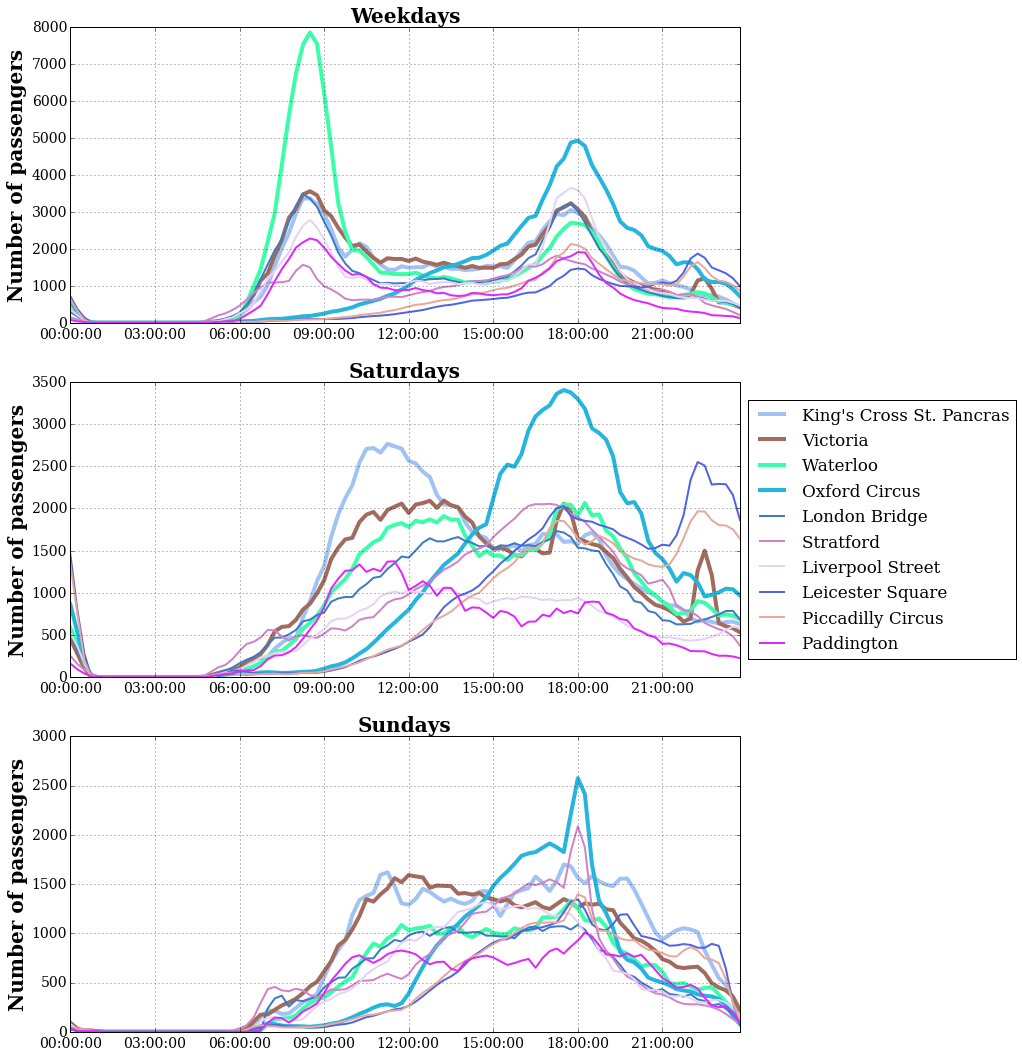

In [304]:
plt.figure(figsize = (12,18))

###Time series plot for week days
plt.subplot(311)
timeseries_plot(modify_df_for_TS_plot(data_counts_week, mask), c,n_bs)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Weekdays', fontweight = 'bold', fontsize = 20)

###Time series plot for Saturdays
plt.subplot(312)
timeseries_plot(modify_df_for_TS_plot(data_counts_sat, mask), c,n_bs)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Saturdays', fontweight = 'bold', fontsize = 20)

###Time series plot for Sundays
plt.subplot(313)
timeseries_plot(modify_df_for_TS_plot(data_counts_sun, mask), c,n_bs)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Sundays', fontweight = 'bold', fontsize = 20)

 - During Weekdays passenger distribution is kind of bimodel for a number of stations, mainly railway stations (e.g. Waterloo, Victoria, Liverpool Street). People come to work in London from other places in UK. 
 - A singal peak around 6pm can be observed for Oxford street station for Weekdays, Saturdays and Sundays. Potentially can be explained by people going shopping.
 - Leicester Square station is busy on Saturday night. Londoners are going out to pubs/bars/restraunts in that area. 


------

##Oyster card data analysis

###What is the mean travel time by London Underground?

In [305]:
data_oyster_tube['travel_time'] = data_oyster_tube['ExTime'] - data_oyster_tube['EntTime']

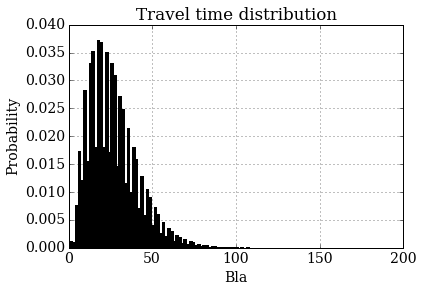

In [306]:
n, bins, patches = plt.hist(np.array(data_oyster_tube['travel_time']),bins = 100, color = 'black', normed = 1)
plt.grid(True)
plt.xlim([0,200])
plt.ylabel('Probability')
plt.xlabel('Bla')
plt.title('Travel time distribution')

In [307]:
data_oyster_tube['travel_time'].describe()

count    679082.000000
mean         26.770202
std          15.002303
min          -1.000000
25%          16.000000
50%          24.000000
75%          35.000000
max         161.000000
dtype: float64

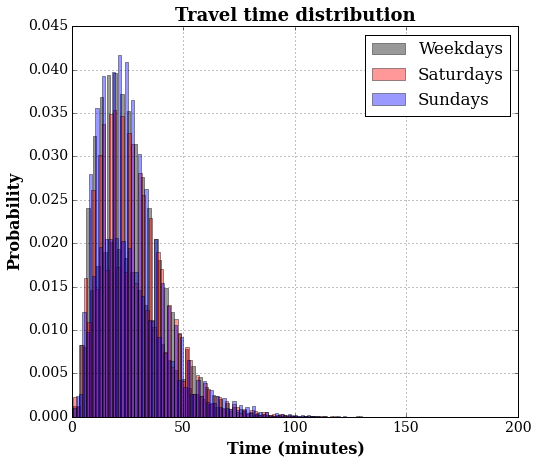

In [308]:
plt.figure(figsize = (8,7))
n, bins, patches = plt.hist(np.array(data_oyster_tube[(data_oyster_tube['daytype'] != 'Sat') 
                                            & (data_oyster_tube['daytype'] != 'Sun')]['travel_time']),
                            bins = 100, color = 'k', normed = 1, alpha = 0.4, label = 'Weekdays')
n, bins, patches = plt.hist(np.array(data_oyster_tube[data_oyster_tube['daytype'] == 'Sat']['travel_time']),
                            bins = 100, color = 'r', normed = 1, alpha = 0.4, label = 'Saturdays')
n, bins, patches = plt.hist(np.array(data_oyster_tube[data_oyster_tube['daytype'] == 'Sun']['travel_time']),
                            bins = 100, color = 'b', normed = 1, alpha = 0.4, label = 'Sundays')


plt.grid(True)
plt.xlim([0,200])
plt.ylabel('Probability', fontweight = 'bold', fontsize = 16)
plt.xlabel('Time (minutes)', fontweight = 'bold', fontsize = 16)
plt.title('Travel time distribution', fontweight = 'bold', fontsize = 18)
plt.legend()

In [309]:
print "Mean travel time"
print np.mean(np.array(data_oyster_tube['travel_time']))

print "Standard deviation"
print np.std(np.array(data_oyster_tube['travel_time']))

Mean travel time
26.7702015368
Standard deviation
15.0022922083


--------

###What are the most popular routes in London Underground?

In [310]:
data_oyster_tube['Route'] = data_oyster_tube['StartStn'] + ' to ' + data_oyster_tube['EndStation']

In [311]:
#The most popular routes on Weekdays
data_oyster_tube[(data_oyster_tube['daytype'] != 'Sat') & (data_oyster_tube['daytype'] != 'Sun')]['Route'].value_counts().head(5)

Canary Wharf to Waterloo JLE     980
Waterloo JLE to Canary Wharf     969
Oxford Circus to Victoria        927
Victoria to Oxford Circus        925
Canary Wharf to London Bridge    867
dtype: int64

In [312]:
#The most popular routes on Saturdays
data_oyster_tube[data_oyster_tube['daytype'] == 'Sat']['Route'].value_counts().head(5)

London Bridge to Angel               91
Oxford Circus to Waterloo            90
London Bridge to Kings Cross T       80
Leicester Square to Waterloo         76
Liverpool Street to Oxford Circus    72
dtype: int64

In [313]:
#The most popular routes on Sundays
data_oyster_tube[data_oyster_tube['daytype'] == 'Sun']['Route'].value_counts().head(5)

Kings Cross T to Victoria                 89
Kings Cross T to London Bridge            72
London Bridge to Waterloo JLE             71
Waterloo JLE to London Bridge             62
Shepherd's Bush Und to Ealing Broadway    52
dtype: int64

------------

###How are the most popular routes in London Underground change over a day?

In [314]:
data_oyster_tube = data_oyster_tube.apply(lambda x: x.str.replace('24:', '00:'))
data_oyster_tube = data_oyster_tube.apply(lambda x: x.str.replace('25:', '01:'))

In [315]:
def most_popular_route_by_hour(df, title_label):
    df['Count']= 1
    df.index.names = ['Date']
    df1 = df.groupby(['Route']).resample('1H', how='count')
    df1 = df1.reset_index()
    
    df1_pivoted = df1.pivot_table('Count', ['Route'], 'Date')
    df1_pivoted.columns = np.arange(24)
        
    df2 = df1_pivoted.max(axis=0, skipna=True)
    df2 = pd.concat([df1_pivoted.idxmax(axis=0, skipna=True), df1_pivoted.max(axis=0, skipna=True)], axis =1)
    df2=df2.reset_index()
    df2.columns = ['Time','Route','Count']
    df2=df2.drop(df2[df2.Count < 10].index)
    
    ##Plotting##
    c=np.random.rand(3,1)

    marker = itertools.cycle(('s', 'd', '<', 'o', '*','p','^','h')) 
    plt.figure(figsize = (15,10))
    for i, group in df2.groupby('Route'):
        x = group.Time
        y= group.Count
        plt.plot(group.Time, group.Count, marker = marker.next(),markersize= 20, linestyle = '', 
                 color  = np.random.rand(3,1), label = str(i),clip_on=False)
    plt.legend(loc='left', bbox_to_anchor=(1.05, 1.01),
              fancybox=True, shadow=True, ncol=1, fontsize = 20)

    plt.xlabel('Hour', fontsize = 30, fontweight = 'bold')
    plt.ylabel('# of Oyster trips', fontsize = 30, fontweight = 'bold')
    plt.tick_params(labelsize = 20)
    plt.xlim([0,24.5])
    plt.grid(True)
    plt.title(('Most popular routes ' + '('+title_label+')'), fontsize = 30, fontweight = 'bold',y=1.04)
    
    return df2

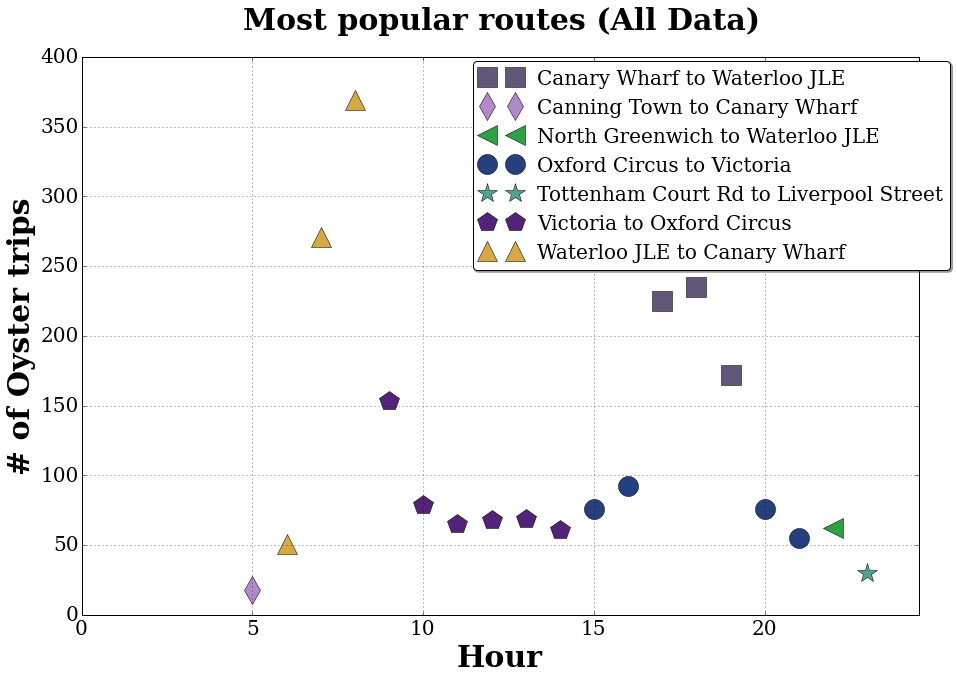

In [ ]:
data_oyster_tube_sub = data_oyster_tube[['Route']]
data_oyster_tube_sub.index = [datetime.strptime(t, '%H:%M') for t in data_oyster_tube['EntTimeHHMM']]

_ = most_popular_route_by_hour(data_oyster_tube_sub, 'All Data')

In [ ]:
data_oyster_tube_weekdays  = data_oyster_tube[(data_oyster_tube['daytype'] != 'Sat') 
                                            & (data_oyster_tube['daytype'] != 'Sun')]
data_oyster_tube_weekdays_sub =data_oyster_tube_weekdays[['Route']]
data_oyster_tube_weekdays_sub.index = [datetime.strptime(t, '%H:%M') for t in data_oyster_tube_weekdays['EntTimeHHMM']]

_ = most_popular_route_by_hour(data_oyster_tube_weekdays_sub, 'WeekDays')

In [ ]:
data_oyster_tube_weekends  = data_oyster_tube[(data_oyster_tube['daytype'] == 'Sat') 
                                           | (data_oyster_tube['daytype'] == 'Sun')]
data_oyster_tube_weekends_sub =data_oyster_tube_weekends[['Route']]
data_oyster_tube_weekends_sub.index = [datetime.strptime(t, '%H:%M') for t in data_oyster_tube_weekends['EntTimeHHMM']]

_ = most_popular_route_by_hour(data_oyster_tube_weekends_sub, 'WeekEnd')

--------

## Visulazitation with Folium package

In [ ]:
import folium
map_ldn = folium.Map(location=[51.5072, 0.1275])
folium.Marker([51.5, 0.1275], popup='Mt. Hood Meadows').add_to(map_1)
#folium.Marker([45.3311, -121.7113], popup='Timberline Lodge').add_to(map_1)